In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.interpolate import UnivariateSpline
import lmfit
import ray


from bio_optics.water import absorption, attenuation, backscattering, scattering, lee
from bio_optics.atmosphere import downwelling_irradiance
from bio_optics.models import hereon, model, bandratioIOPprediction
from bio_optics.helper import resampling, utils, owt, indices, plotting

# Analysing Spec Balaton data
The inversion of these spectra do not yield good estimates of concentrations yet. Idea: use group concentrations as fixed values, broaden the ranges of other parameters. E.g. backscattering ratio can become quite large for cyanoblooms, which is not considered yet. This analysis may also need the split of the backscattering ratio in mineralogenic and biogenic parts!

In [5]:
## Jorge: Spec Balaton
df = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\Database\Others\SpecBal_EnMap.txt', index_col=0)

r_rs = df.iloc[:,:56] 
wavelengths = df.columns[:56].values.astype(float)
print(df.columns.values)

['418.2' '423.9' '429.3' '434.5' '439.6' '444.5' '449.4' '454.2' '458.9'
 '463.6' '468.3' '472.9' '477.6' '482.3' '486.9' '491.6' '496.3' '501.1'
 '505.9' '510.7' '515.5' '520.4' '525.3' '530.3' '535.3' '540.3' '545.4'
 '550.5' '555.7' '560.9' '566.2' '571.6' '577.0' '582.5' '588.0' '593.6'
 '599.3' '605.0' '610.8' '616.7' '622.7' '628.8' '634.9' '641.1' '647.3'
 '653.6' '660.0' '666.4' '672.9' '679.5' '686.1' '692.8' '699.6' '706.4'
 '713.3' '720.3' '727.3' '734.4' '741.6' '748.8' '756.1' '763.5' '770.9'
 '778.3' '785.8' '793.4' 'Date/Time' 'Lat' 'Lon' 'Location' 'Set' 'QWIP'
 'NDI' 'AVW' 'W_Chl' 'W_TSM' 'W_Kd' 'W_CPC' 'Turbidity' 'CDOM' 'Diatoms'
 'Cryptophyta' 'Planktothrix' 'Green_algae' 'Ratio' 'Chl_a' 'Cyano']


## Inversion

In [6]:
from bio_optics.water import fluorescence

# global inputs that don't change with fit params
a_md_spec_res = absorption.a_md_spec(wavelengths=wavelengths)
a_bd_spec_res = absorption.a_bd_spec(wavelengths=wavelengths)
a_w_res = resampling.resample_a_w(wavelengths=wavelengths)
a_i_spec_res = resampling.resample_a_i_spec_EnSAD(wavelengths=wavelengths)
b_bw_res = backscattering.b_bw(wavelengths=wavelengths, fresh=False)
b_i_spec_res = resampling.resample_b_i_spec_EnSAD(wavelengths=wavelengths)
da_W_div_dT_res = resampling.resample_da_W_div_dT(wavelengths=wavelengths)
h_C_res = fluorescence.h_C_double(wavelengths=wavelengths, W=0.75)
h_C_phycocyanin_res = fluorescence.h_C(wavelengths=wavelengths, fwhm=20, lambda_C=644)
h_C_phycoerythrin_res =fluorescence.h_C(wavelengths=wavelengths, fwhm=20, lambda_C=573)
omega_d_lambda_0_res = attenuation.omega_d_lambda_0()

E_0_res = resampling.resample_E_0(wavelengths=wavelengths)
a_oz_res = resampling.resample_a_oz(wavelengths=wavelengths)
a_ox_res = resampling.resample_a_ox(wavelengths=wavelengths)
a_wv_res = resampling.resample_a_wv(wavelengths=wavelengths)
n2_res = resampling.resample_n(wavelengths=wavelengths)

E_dd_res = downwelling_irradiance.E_dd(wavelengths=wavelengths)
E_dsa_res = downwelling_irradiance.E_dsa(wavelengths=wavelengths)
E_dsr_res = downwelling_irradiance.E_dsr(wavelengths=wavelengths)
E_d_res = E_dd_res + E_dsa_res + E_dsr_res

In [7]:
weights = np.ones(len(wavelengths))

In [8]:
params = lmfit.Parameters()
params.add('C_0', value=0, min=0, max=1000, vary=True) # brown
params.add('C_1', value=1, min=1e-10, max=1000, vary=True) # green
params.add('C_2', value=0, min=0, max=1000, vary=True) # cryptophyte
params.add('C_3', value=0, min=0, max=1000, vary=True) # cyano blue
params.add('C_4', value=0, min=0, max=1000, vary=True) # cyano red
params.add('C_5', value=0, min=0, max=1000, vary=False) # coccolithophores
params.add('C_6', value=0, min=0, max=1000, vary=False) # dinoflagellates
params.add('C_7', value=0, min=0, max=1000, vary=False) # case-1
params.add('C_Y', value=0.1, min=0, max=20, vary=True) 
params.add('C_ism', value=1, min=0, max=100, vary=True)
params.add('L_fl_lambda0', value=0, min=0, max=0.2, vary=True)
params.add('L_fl_phycocyanin', value=0, min=0, max=0.2, vary=True)
params.add('L_fl_phycoerythrin', value=0, min=0, max=0.2, vary=True)
params.add('b_ratio_C_0', value=0.002, vary=False) # brown
params.add('b_ratio_C_1', value=0.007, vary=False) # green
params.add('b_ratio_C_2', value=0.002, vary=False) # cryptophyte
params.add('b_ratio_C_3', value=0.001, vary=False) # cyano blue
params.add('b_ratio_C_4', value=0.001, vary=False) # cyano red
params.add('b_ratio_C_5', value=0.007, vary=False) # coccolithophores
params.add('b_ratio_C_6', value=0.007, vary=False) # dinoflagellates , chose 0.007 because of smaller cell size
params.add('b_ratio_C_7', value=0.007, vary=False) # case-1
params.add('b_ratio_md', value=0.0216, min=0.021, max=0.3756, vary=True) # max=0.0756
params.add('b_ratio_bd', value=0.0216, min=0.021, max=0.3756, vary=True) # max=0.0756
params.add('A_md', value=13.4685e-3, vary=False)
params.add('A_bd', value=0.3893e-3, vary=False)
params.add('S_md', value=10.3845e-3, vary=False)
params.add('S_bd', value=15.7621e-3, vary=False)
params.add('S_cdom', value=0.0185, min=0.005, max=0.032, vary=True)
params.add('C_md', value=12.1700e-3, vary=False)
params.add('C_bd', value=0.9994e-3, vary=False)
params.add('K', value=0, min=0, vary=False)
params.add('lambda_0_cdom', value=440, vary=False)
params.add('lambda_0_md', value=550, vary=False)
params.add('lambda_0_bd', value=550, vary=False)
params.add('lambda_0_c_d', value=550, vary=False)
params.add('lambda_0_phy', value=676, vary=False)
params.add('gamma_d', value=0.3835, vary=False)
params.add('x0', value=1, vary=False)
params.add('x1', value=10, vary=False)
params.add('x2', value=-1.3390, min=-1.3390-0.0618, max=-1.3390+0.0618, vary=False)
params.add('A', value=0.0237, vary=False)
params.add('E0', value=1, vary=False)
params.add('E1', value=0.8987, vary=False)
params.add('W', value=0.75, vary=False) 
params.add('fwhm1', value=25, vary=False)
params.add('fwhm2', value=50, vary=False)
params.add('fwhm_phycocyanin', value=20, vary=False)
params.add('fwhm_phycoerythrin', value=20, vary=False)
params.add('lambda_C1', value=685, vary=False)
params.add('lambda_C2', value=730, vary=False)
params.add('lambda_C_phycocyanin', value=644, vary=False)
params.add('lambda_C_phycoerythrin', value=573, vary=False)
params.add('double', value=True, vary=False)
params.add('interpolate', value=True, vary=False)
params.add("Gw0", value=0.05881474, vary=False)
params.add("Gw1", value=0.05062697, vary=False)
params.add("Gp0", value=0.03997009, vary=False)
params.add("Gp1", value=0.1398902, vary=False)
params.add('error_method', value=0, vary=False)
params.add('theta_sun', value=np.radians(30), min=np.radians(0), max=np.radians(90), vary=False)
params.add('theta_view', value=np.radians(1e-10), min=np.radians(1e-10), max=np.radians(90), vary=False)
params.add('n1', value=1, vary=False)
params.add('n2', value=1.33, vary=False)
params.add('kappa_0', value=1.0546, vary=False)
params.add('fresh', value=False, vary=False)
params.add('T_W', value=25, min=0, max=40, vary=False)
params.add('T_W_0', value=20, vary=False)
params.add('P', value=1013.25, vary=False) 
params.add('AM', value=1, vary=False) 
params.add('RH', value=60, vary=False) 
params.add('H_oz', value=0.38, vary=False)
params.add('WV', value=2.5, vary=False) 
params.add('alpha', value=1.317, vary=False) 
params.add('beta', value=0.2606, vary=False) 
params.add('g_dd', value=0.02, min=-1, max=10, vary=True) 
params.add('g_dsr', value=1/np.pi, min=0, max=10, vary=True) 
params.add('g_dsa', value=1/np.pi, min=0, max=10, vary=True) 
params.add('d_r', value=0, min=0, max=0.1, vary=True) 
params.add('f_dd', value=1, vary=False) 
params.add('f_ds', value=1, vary=False) 
params.add('offset', value=0, min=-0.1, max=0.1, vary=False) #min= -0.1
params.add('fit_surface', value=True, vary=True)

In [9]:
PhytoConcInsituCol = ['Diatoms', 'Green_algae', 'Cryptophyta', 'Cyano', 'CDOM', 'Turbidity']
a = np.zeros(df.shape[0])
for phyto in PhytoConcInsituCol[:4]:
    print(phyto, np.sum(np.isnan(df[phyto].values)))
    a += np.isnan(df[phyto].values)
ID = np.array(a==0)
print(np.sum(ID), len(a))

df = df.loc[ID,:]
r_rs = r_rs.loc[ID,:]

Diatoms 685
Green_algae 685
Cryptophyta 685
Cyano 0
294 979


## Inversion with fixed values per spectrum

In [10]:
# print(r_rs.shape[0])
plotThis = False

PhytoConcInsituCol = ['Diatoms', 'Green_algae', 'Cryptophyta', 'Cyano', 'CDOM', 'Turbidity']
for phyto in PhytoConcInsituCol:
    print(phyto, np.sum(np.isnan(df[phyto].values)))

out = None
R_rs_surf = np.zeros((r_rs.shape[0], len(wavelengths)))
R_rs_sim = np.zeros((r_rs.shape[0], len(wavelengths)))

for i in range(r_rs.shape[0]):
# print(df[PhytoConcInsituCol].iloc[i])
    chunk_params = params.copy()
    # set fixed concentration values, from table: 'Diatoms' 'Cryptophyta' 'Planktothrix' 'Green_algae' 'Ratio' 'Chl_a' 'Cyano'
    # chunk_params.add('C_0', value=df['Diatoms'].values[i], vary=False) # brown
    # chunk_params.add('C_1', value=df['Green_algae'].values[i], vary=False) # green
    # chunk_params.add('C_2', value=df['Cryptophyta'].values[i], vary=False) # cryptophyte
    # chunk_params.add('C_3', value=df['Cyano'].values[i], vary=False) # cyano blue
    # chunk_params.add('C_Y', value=df['CDOM'].values[i], vary=False) # CDOM
    FreeParamList = [a for a in chunk_params.keys() if chunk_params[a].vary]
    inv = hereon.invert(chunk_params, 
                        R_rs=r_rs.iloc[i,:],
                        Ls_Ed = [],
                        wavelengths=wavelengths, 
                        weights=weights,
                        a_md_spec_res = a_md_spec_res,
                        a_bd_spec_res = a_bd_spec_res,
                        a_w_res = a_w_res,
                        a_i_spec_res = a_i_spec_res,
                        b_bw_res = b_bw_res, 
                        b_i_spec_res = b_i_spec_res,
                        h_C_res = h_C_res,
                        h_C_phycocyanin_res=h_C_phycocyanin_res,
                        h_C_phycoerythrin_res=h_C_phycoerythrin_res,
                        da_W_div_dT_res = da_W_div_dT_res,
                        E_0_res = E_0_res,
                        a_oz_res = a_oz_res,
                        a_ox_res = a_ox_res,
                        a_wv_res = a_wv_res,
                        E_dd_res = E_dd_res,
                        E_dsa_res = E_dsa_res,
                        E_dsr_res = E_dsr_res,
                        E_d_res = E_d_res,
                        n2_res = n2_res,
                        method="least_squares",
                        max_nfev=1500)

    if out is None:
        out = np.zeros((r_rs.shape[0], len(FreeParamList)))
    for j, p in enumerate(FreeParamList):
        # print(p, np.round(inv.params[p].value,4))
        out[i, j] = inv.params[p].value

    if params['fit_surface'].value:
        R_rs_surf[i,:] = model.forward_glint(wavelengths=wavelengths,
                                    parameters=inv.params,
                                    E_d_res=E_d_res,
                                    E_dd_res=E_dd_res,
                                    E_dsa_res=E_dsa_res,
                                    E_dsr_res=E_dsr_res,
                                    n2_res=n2_res,
                                    Ls_Ed=[])


    R_rs_sim[i,:] =hereon.forward(parameters=inv.params, 
                                         wavelengths=wavelengths, 
                                         a_md_spec_res = a_md_spec_res,
                                         a_bd_spec_res = a_bd_spec_res,
                                         a_w_res = a_w_res,
                                         a_i_spec_res = a_i_spec_res,
                                         b_bw_res = b_bw_res, 
                                         b_i_spec_res = b_i_spec_res,
                                         h_C_res=h_C_res,
                                         h_C_phycocyanin_res = h_C_phycocyanin_res,
                                         h_C_phycoerythrin_res = h_C_phycoerythrin_res,
                                         da_W_div_dT_res = da_W_div_dT_res,
                                         E_0_res = E_0_res,
                                         a_oz_res = a_oz_res,
                                         a_ox_res = a_ox_res,
                                         a_wv_res = a_wv_res,
                                         E_dd_res = E_dd_res,
                                         E_dsa_res = E_dsa_res,
                                         E_dsr_res = E_dsr_res,
                                         E_d_res = E_d_res,
                                         n2_res = n2_res,
                                         Ls_Ed=[])
    
    if plotThis:
        plt.plot(wavelengths, r_rs.iloc[i], c='#0f7f9b', label="measured")
        plt.plot(wavelengths, hereon.forward(parameters=inv.params, 
                                         wavelengths=wavelengths, 
                                         a_md_spec_res = a_md_spec_res,
                                         a_bd_spec_res = a_bd_spec_res,
                                         a_w_res = a_w_res,
                                         a_i_spec_res = a_i_spec_res,
                                         b_bw_res = b_bw_res, 
                                         b_i_spec_res = b_i_spec_res,
                                         h_C_res=h_C_res,
                                         h_C_phycocyanin_res = h_C_phycocyanin_res,
                                         h_C_phycoerythrin_res = h_C_phycoerythrin_res,
                                         da_W_div_dT_res = da_W_div_dT_res,
                                         E_0_res = E_0_res,
                                         a_oz_res = a_oz_res,
                                         a_ox_res = a_ox_res,
                                         a_wv_res = a_wv_res,
                                         E_dd_res = E_dd_res,
                                         E_dsa_res = E_dsa_res,
                                         E_dsr_res = E_dsr_res,
                                         E_d_res = E_d_res,
                                         n2_res = n2_res,
                                         Ls_Ed=[]), '--', c='red', label='modeled')
        # if results[i].params['fit_surface'].value:
            # plt.plot(wavelengths, R_rs_surf, c='skyblue', label="glint")
            # plt.plot(wavelengths, r_rs.iloc[i] - R_rs_surf, c='darkblue', label="measured - glint")
        plt.xlabel('$\lambda$ [nm]')
        plt.ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
        plt.hlines(0,300,1000, color='black', linewidth=0.5) #, linestyle='dotted')
        plt.xlim(np.min(wavelengths)-10,np.max(wavelengths)+10)
        # plt.ticklabel_format(style='scientific')
        plt.legend()
        plt.show()


Diatoms 0
Green_algae 0
Cryptophyta 0
Cyano 0
CDOM 0
Turbidity 223


In [11]:
## write modelled spectra
outpath = r"E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\analyse_SpecBal\\"
R_rs_surf = pd.DataFrame(R_rs_surf, columns=wavelengths.astype(str))
# R_rs_surf.to_csv(outpath + "inversion_RrsGlint_SpecBal_withGlint_md_bd.txt", header=True, sep='\t', index=False)
# R_rs_surf.to_csv(outpath + "inversion_RrsGlint_SpecBal_FixedChl4_withPosGlint_md_bd.txt", header=True, sep='\t', index=False)
# R_rs_surf.to_csv(outpath + "inversion_RrsGlint_SpecBal_varChl_withPosGlint_md_bd.txt", header=True, sep='\t', index=False)
R_rs_surf.to_csv(outpath + "inversion_RrsGlint_SpecBal_varChl_withPosGlint_md_bd_conFL.txt", header=True, sep='\t', index=False)

R_rs_sim = pd.DataFrame(R_rs_sim, columns=wavelengths.astype(str))
# R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_FixedChl4_withGlint_md_bd.txt", header=True, sep='\t', index=False)
# R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_FixedChl4_offset_md_bd.txt", header=True, sep='\t', index=False)
# R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_FixedChl4_NaN_md_bd.txt", header=True, sep='\t', index=False)
# R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_FixedChl4_withPosGlint_md_bd.txt", header=True, sep='\t', index=False)
# R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_varChl_withPosGlint_md_bd.txt", header=True, sep='\t', index=False)
R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_varChl_withPosGlint_md_bd_conFL.txt", header=True, sep='\t', index=False)

In [12]:
outDF = pd.DataFrame(out, columns=FreeParamList)
print(FreeParamList)

outpath = r"E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\analyse_SpecBal\\"
# outDF.to_csv(outpath + "SpecBal_FixedChl4_withGlint_md_bd.txt", sep='\t', header=True, index=False)
# outDF.to_csv(outpath + "SpecBal_FixedChl4_offset_md_bd.txt", sep='\t', header=True, index=False)
# outDF.to_csv(outpath + "SpecBal_FixedChl4_NaN_md_bd.txt", sep='\t', header=True, index=False)
# outDF.to_csv(outpath + "SpecBal_FixedChl4_withPosGlint_md_bd.txt", sep='\t', header=True, index=False)
# outDF.to_csv(outpath + "SpecBal_varChl_withPosGlint_md_bd.txt", sep='\t', header=True, index=False)
outDF.to_csv(outpath + "SpecBal_varChl_withPosGlint_md_bd_conFL.txt", sep='\t', header=True, index=False)

['C_0', 'C_1', 'C_2', 'C_3', 'C_4', 'C_Y', 'C_ism', 'L_fl_lambda0', 'L_fl_phycocyanin', 'L_fl_phycoerythrin', 'b_ratio_md', 'b_ratio_bd', 'S_cdom', 'g_dd', 'g_dsr', 'g_dsa', 'd_r', 'fit_surface']


In [32]:
R_rs_surf = np.zeros((outDF.shape[0], len(wavelengths)))
R_rs_sim = np.zeros((outDF.shape[0], len(wavelengths)))

for i in range(outDF.shape[0]):
    chunk_params = params.copy()
    # set fixed concentration values, from table: 'Diatoms' 'Cryptophyta' 'Planktothrix' 'Green_algae' 'Ratio' 'Chl_a' 'Cyano'
    # chunk_params.add('C_0', value=df['Diatoms'].values[i], vary=False) # brown
    # chunk_params.add('C_1', value=df['Green_algae'].values[i], vary=False) # green
    # chunk_params.add('C_2', value=df['Cryptophyta'].values[i], vary=False) # cryptophyte
    # chunk_params.add('C_3', value=df['Cyano'].values[i], vary=False) # cyano blue
    # chunk_params.add('C_Y', value=df['CDOM'].values[i], vary=False) # CDOM
    
    for p in outDF.columns.values:
        chunk_params.add(p, value=outDF[p].values[i]) 
    
    if params['fit_surface'].value:
        ## run forward processing for goodness of fit estimates
        R_rs_surf[i,:] = model.forward_glint(wavelengths=wavelengths,
                                    parameters=chunk_params,
                                    E_d_res=E_d_res,
                                    E_dd_res=E_dd_res,
                                    E_dsa_res=E_dsa_res,
                                    E_dsr_res=E_dsr_res,
                                    n2_res=n2_res,
                                    Ls_Ed=[])
    R_rs_sim[i,:] = hereon.forward(parameters=chunk_params, #results[i].params
                                     wavelengths=wavelengths, 
                                     a_md_spec_res = a_md_spec_res,
                                     a_bd_spec_res = a_bd_spec_res,
                                     a_w_res = a_w_res,
                                     a_i_spec_res = a_i_spec_res,
                                     b_bw_res = b_bw_res, 
                                     b_i_spec_res = b_i_spec_res,
                                     h_C_res=h_C_res,
                                     h_C_phycocyanin_res = h_C_phycocyanin_res,
                                     h_C_phycoerythrin_res = h_C_phycoerythrin_res,
                                     da_W_div_dT_res = da_W_div_dT_res,
                                     E_0_res = E_0_res,
                                     a_oz_res = a_oz_res,
                                     a_ox_res = a_ox_res,
                                     a_wv_res = a_wv_res,
                                     E_dd_res = E_dd_res,
                                     E_dsa_res = E_dsa_res,
                                     E_dsr_res = E_dsr_res,
                                     E_d_res = E_d_res,
                                     n2_res = n2_res,
                                     Ls_Ed=[])

    


In [24]:
R_rs_surf2 = pd.DataFrame(R_rs_surf2, columns=wavelengths.astype(str))
R_rs_sim2 = pd.DataFrame(R_rs_sim2, columns=wavelengths.astype(str))

In [27]:
## write modelled spectra
outpath = r"E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\analyse_SpecBal\\"
# if params['fit_surface'].value:
#     R_rs_sim = pd.DataFrame(R_rs_sim, columns=wavelengths.astype(str))
#     R_rs_surf = pd.DataFrame(R_rs_surf, columns=wavelengths.astype(str))
#     R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_withGlint.txt", header=True, sep='\t', index=False)
#     R_rs_surf.to_csv(outpath + "inversion_RrsGlint_SpecBal_withGlint.txt", header=True, sep='\t', index=False)
# else:
#     R_rs_sim = pd.DataFrame(R_rs_sim, columns=wavelengths.astype(str))
#     R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_noGlint.txt", header=True, sep='\t', index=False)

R_rs_surf = pd.DataFrame(R_rs_surf, columns=wavelengths.astype(str))
# R_rs_surf.to_csv(outpath + "inversion_RrsGlint_SpecBal_withGlint_md_bd.txt", header=True, sep='\t', index=False)

R_rs_sim = pd.DataFrame(R_rs_sim, columns=wavelengths.astype(str))
# R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_FixedChl4CDOM_noGlint.txt", header=True, sep='\t', index=False)
# R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_FixedChl4_noGlint_md_bd.txt", header=True, sep='\t', index=False)
# R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_FixedChl4_withGlint_md_bd.txt", header=True, sep='\t', index=False)


In [13]:
ID = np.sum(R_rs_surf< 0, axis=1)
# ID2 = np.sum(R_rs_surf2< 0, axis=1)
print(np.sum(ID>0))

0


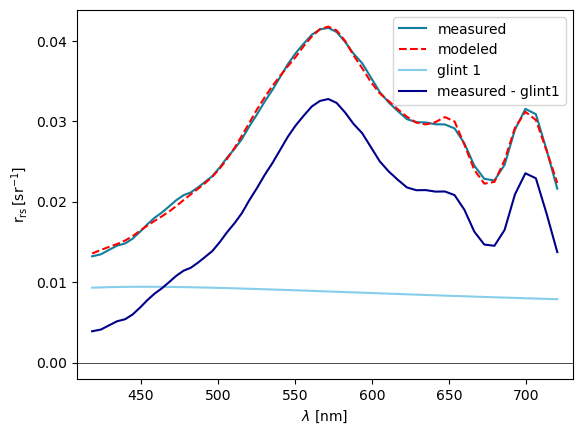

In [13]:
i=15
# print(df[PhytoConcInsituCol].iloc[i,:])
# print(np.round(outDF.iloc[i,:],4))
plt.plot(wavelengths, r_rs.iloc[i], c='#0f7f9b', label="measured")
plt.plot(wavelengths, R_rs_sim.iloc[i,:], '--', c='red', label='modeled')
# plt.plot(wavelengths, R_rs_sim2.iloc[i,:], '-.', c='salmon', label='modeled 2')
if params['fit_surface'].value:
    # plt.plot(wavelengths, R_rs_surf[i,:], c='skyblue', label="glint")
    plt.plot(wavelengths, R_rs_surf.iloc[i,:], c='skyblue', label="glint 1")
    # plt.plot(wavelengths, R_rs_surf2.iloc[i,:], c='slateblue', label="glint 2")
    plt.plot(wavelengths, r_rs.iloc[i] - R_rs_surf.iloc[i,:], c='darkblue', label="measured - glint1")
plt.xlabel('$\lambda$ [nm]')
plt.ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
plt.hlines(0,300,1000, color='black', linewidth=0.5) #, linestyle='dotted')
plt.xlim(np.min(wavelengths)-10,np.max(wavelengths)+10)
# plt.ticklabel_format(style='scientific')
plt.legend()
plt.show()

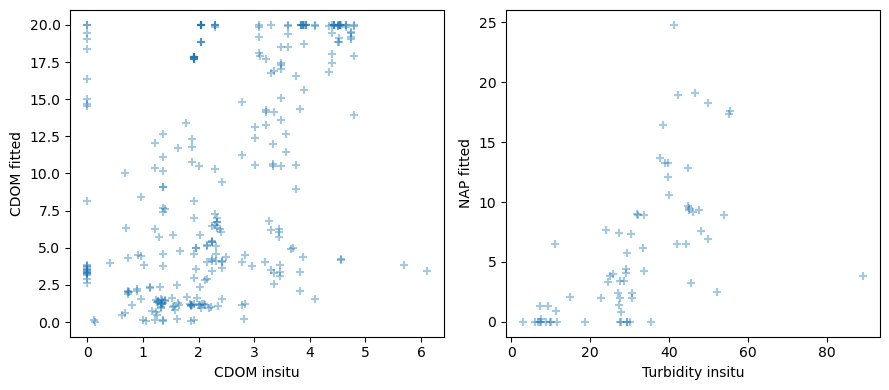

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
ax[0].scatter(df['CDOM'], outDF['C_Y'], marker='+', alpha=0.4)
ax[1].scatter(df['Turbidity'], outDF['C_ism'], marker='+', alpha=0.4)
ax[0].set_xlabel('CDOM insitu')
ax[0].set_ylabel('CDOM fitted')
ax[1].set_xlabel('Turbidity insitu')
ax[1].set_ylabel('NAP fitted')
fig.tight_layout()

## Check / compare previous results
### IOPs and fit parameter

In [15]:
path =  r"E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\analyse_SpecBal\\"
IOPResultDict = {
    # 'chl4_wG' : {
    #     'fname': "SpecBal_FixedChl4_withGlint.txt"
    # },
    # 'chl4_nG' : {
    #     'fname': "SpecBal_FixedChl4_noGlint.txt"
    # },
    # 'chl4_CDOM_nG':{
    #     'fname': "SpecBal_FixedChl4CDOM_noGlint.txt"
    # },
    # 'chl4_wG_md_bd':{
    #     'fname': "SpecBal_FixedChl4_withGlint_md_bd.txt",
    #     'col': 'b'
    # },
    # 'chl4_offset_md_bd':{
    #     'fname': "SpecBal_FixedChl4_offset_md_bd.txt",
    #     'col':'r'
    # },
    # 'chl4_NaN_md_bd':{
    #     'fname': "SpecBal_FixedChl4_NaN_md_bd.txt",
    #     'col':'magenta'
    # }, 
    'chl4_wGp_md_bd':{
        'fname': "SpecBal_FixedChl4_withPosGlint_md_bd.txt",
        'col': 'g'
    },
    'varchl_wGp_md_bd':{
        'fname': "SpecBal_varChl_withPosGlint_md_bd.txt",
        'col': 'salmon'
    },
    'varchl_wGp_md_bd_conFL':{
        'fname': "SpecBal_varChl_withPosGlint_md_bd_conFL.txt",
        'col': 'b'
    },
}

dDict = {}
for key in IOPResultDict.keys():
    dDict[key] = pd.read_csv(outpath + IOPResultDict[key]['fname'], sep='\t', header=0)

# dglint = pd.read_csv(outpath + "SpecBal_FixedChl4_withGlint.txt", sep='\t', header=0)
# dnoglint = pd.read_csv(outpath + "SpecBal_FixedChl4_noGlint.txt", sep='\t', header=0)
# cnoglint = pd.read_csv(outpath + "SpecBal_FixedChl4CDOM_noGlint.txt", sep='\t', header=0)
# dglint_bd_md = pd.read_csv(outpath + "SpecBal_FixedChl4_withGlint_md_bd.txt", sep='\t', header=0)
# dnoglint_bd_md = pd.read_csv(outpath + "SpecBal_FixedChl4_noGlint_md_bd.txt", sep='\t', header=0)


['C_Y' 'C_ism' 'L_fl_lambda0' 'L_fl_phycocyanin' 'L_fl_phycoerythrin'
 'S_cdom' 'b_ratio_bd' 'b_ratio_md' 'd_r' 'fit_surface' 'g_dd' 'g_dsa'
 'g_dsr']


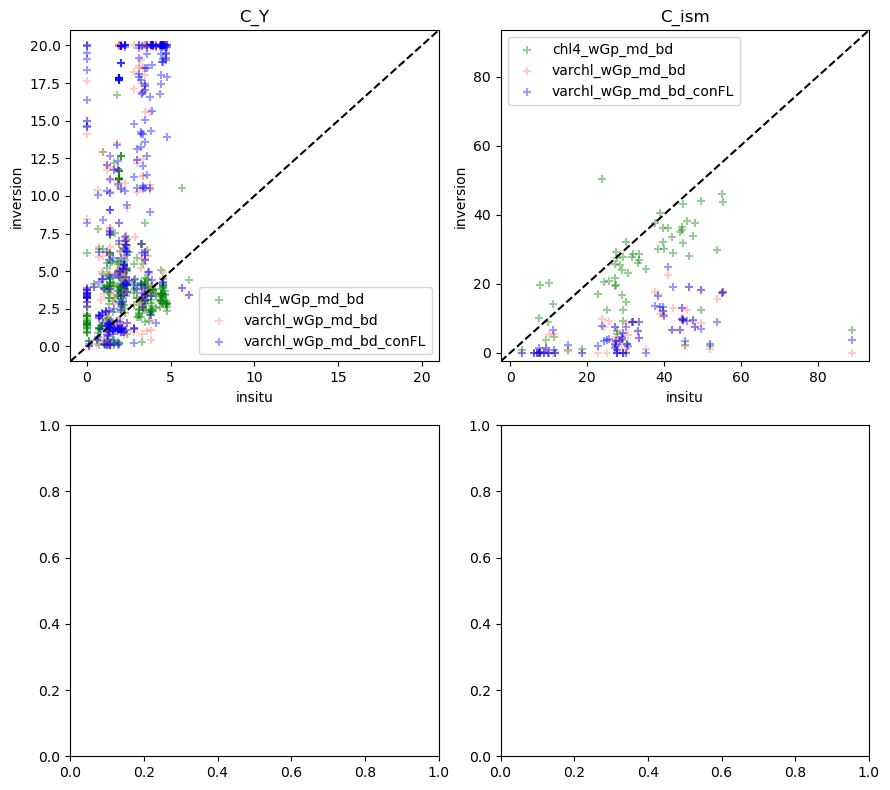

In [16]:
a = None
b = None
for key in dDict.keys():
    if a is None:
        a = dDict[key].columns.values
    if b is None:
        b = dDict[key].columns.values
        commonCol = np.intersect1d(np.asarray(a), np.asarray(b))
    if (not a is None) and (not b is None):
        b = dDict[key].columns.values
        commonCol = np.intersect1d(np.asarray(commonCol), np.asarray(b))

print(commonCol)
colorMap = plt.cm.get_cmap('Spectral_r')
Nx = 2
Ny = 2
ix, iy = (0,0)
fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(9,8))
for v in commonCol[:2]:
    if v == 'C_Y':
        for key in dDict.keys():
            ax[iy,ix].scatter(df['CDOM'], dDict[key][v], marker='+', c=IOPResultDict[key]['col'], alpha=0.4, label=key)
        ax[iy,ix].legend()
        ax[iy,ix].set_xlabel('insitu')
        ax[iy,ix].set_ylabel('inversion')
    elif v== 'C_ism':
        for key in dDict.keys():
            ax[iy,ix].scatter(df['Turbidity'], dDict[key][v], marker='+', c=IOPResultDict[key]['col'], alpha=0.4, label=key)
        ax[iy,ix].legend()
        ax[iy,ix].set_xlabel('insitu')
        ax[iy,ix].set_ylabel('inversion')
        
    ax[iy,ix].set_title(v)

    lim = np.array( (np.min((ax[iy,ix].get_xlim(), ax[iy,ix].get_ylim())), np.max((ax[iy,ix].get_xlim(), ax[iy,ix].get_ylim()))))
    ax[iy,ix].plot(lim, lim, 'k--')
    ax[iy,ix].set_xlim(lim)
    ax[iy,ix].set_ylim(lim)
    ix +=1
    if ix == Nx:
        ix = 0
        iy +=1
fig.tight_layout()
plt.show()



### Spectral comparison

In [17]:
path =  r"E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\analyse_SpecBal\\"
# refKey = 'chl4_NaN_md_bd'
RrsResultDict = {
    # 'chl4_wG_md_bd':{
    #     'fname': "inversion_Rrs_SpecBal_FixedChl4_withGlint_md_bd.txt",
    #     'glint_fname': "inversion_RrsGlint_SpecBal_FixedChl4_withGlint_md_bd.txt",
    #     'col': 'violet'
    # },
    # 'chl4_offset_md_bd':{
    #     'fname': "inversion_Rrs_SpecBal_FixedChl4_offset_md_bd.txt",
    #     'col':'r'
    # },
    #  'chl4_NaN_md_bd':{
    #     'fname': "inversion_Rrs_SpecBal_FixedChl4_NaN_md_bd.txt",
    #     'col':'magenta'
    # },
    'chl4_wGp_md_bd':{
        'fname': "inversion_Rrs_SpecBal_FixedChl4_withPosGlint_md_bd.txt",
        'glint_fname': "inversion_RrsGlint_SpecBal_FixedChl4_withPosGlint_md_bd.txt",
        'col': 'green'
    },
    'varchl_wGp_md_bd':{
        'fname': "inversion_Rrs_SpecBal_varChl_withPosGlint_md_bd.txt",
        'glint_fname': "inversion_RrsGlint_SpecBal_varChl_withPosGlint_md_bd.txt",
        'col': 'salmon'
    },
    'varchl_wGp_md_bd_conFL':{
        'fname': "inversion_Rrs_SpecBal_varChl_withPosGlint_md_bd_conFL.txt",
        'glint_fname': "inversion_RrsGlint_SpecBal_varChl_withPosGlint_md_bd_conFL.txt",
        'col': 'blue'
    }
}

rrsDict = {}
for key in RrsResultDict.keys():
    rrsDict[key] = pd.read_csv(outpath + RrsResultDict[key]['fname'], sep='\t', header=0)
# Rrs_glint = pd.read_csv(outpath + "inversion_Rrs_SpecBal_withGlint.txt", sep='\t', header=0)
# Rrs_noglint = pd.read_csv(outpath + "inversion_Rrs_SpecBal_noGlint.txt", sep='\t', header=0)
# dsurf = pd.read_csv(outpath + "inversion_RrsGlint_SpecBal_withGlint.txt", sep='\t', header=0)
# dsurf_md_bd = pd.read_csv(outpath + "inversion_RrsGlint_SpecBal_withGlint_md_bd.txt", sep='\t', header=0)
# # Rrs_noglint_fCDOM = pd.read_csv(outpath + "inversion_Rrs_SpecBal_FixedChl4CDOM_noGlint.txt", sep='\t', header=0)
# # Rrs_noglint_md_bd = pd.read_csv(outpath + "inversion_Rrs_SpecBal_FixedChl4_noGlint_md_bd.txt", sep='\t', header=0) #todo!!
# Rrs_withglint_md_bd = pd.read_csv(outpath + "inversion_Rrs_SpecBal_FixedChl4_withGlint_md_bd.txt", sep='\t', header=0)

Diatoms         4.52
Green_algae    11.85
Cryptophyta     0.00
Cyano          12.89
CDOM            0.81
Turbidity       7.39
Name: 0, dtype: float64


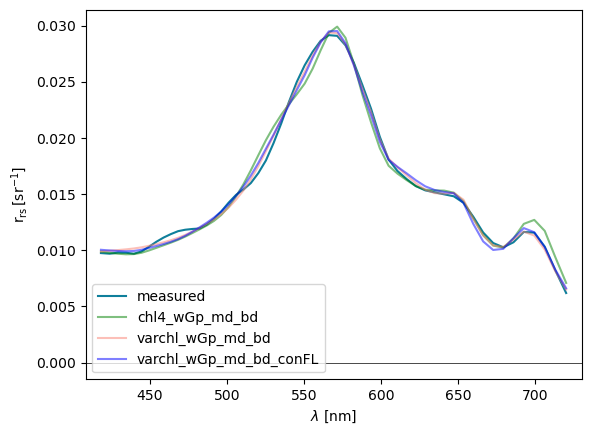

In [18]:
i=0
print(df[PhytoConcInsituCol].iloc[i,:])
plt.plot(wavelengths, r_rs.iloc[i], c='#0f7f9b', label="measured")
for key in rrsDict.keys():
    plt.plot(wavelengths, rrsDict[key].iloc[i,:], '-', c=RrsResultDict[key]['col'], alpha=0.5, label=key)

plt.xlabel('$\lambda$ [nm]')
plt.ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
plt.hlines(0,300,1000, color='black', linewidth=0.5) #, linestyle='dotted')
plt.xlim(np.min(wavelengths)-10,np.max(wavelengths)+10)
# plt.ticklabel_format(style='scientific')
plt.legend()
plt.show()

In [19]:
# Error, Residuals of spectral fit
SpectralErrorDict={}

for key in RrsResultDict.keys():
    rMAE = np.zeros(r_rs.shape[0])
    sam = np.zeros(r_rs.shape[0])
    
    for i in range(len(rMAE)):
        rMAE[i] = np.mean(utils.compute_residual(r_rs.iloc[i].values, rrsDict[key].iloc[i,:].values, method=11))
        sam[i] = np.sum(r_rs.iloc[i].values * rrsDict[key].iloc[i,:].values)/\
                     (np.sqrt(np.sum(r_rs.iloc[i].values*r_rs.iloc[i].values)) * np.sqrt(np.sum(rrsDict[key].iloc[i,:].values*rrsDict[key].iloc[i,:].values)))
        sam[i] = np.arccos(sam[i])
        
    sam *=180./np.pi
    SpectralErrorDict[key] = {}
    SpectralErrorDict[key]['rMAE'] = rMAE
    SpectralErrorDict[key]['SAM'] = sam

    if 'wG' in key: #with glint
        dsurf = pd.read_csv(path + RrsResultDict[key]['glint_fname'], header=0, sep='\t')
        IDnegGlint = np.any(dsurf.values<0, axis=1)
        SumNegGlint = np.zeros(len(sam))
        for i in range(len(SumNegGlint)):
            ID = np.array(dsurf.values[i,:]<0)
            if np.sum(ID)>0:
                SumNegGlint[i] = np.sum(dsurf.values[i,ID])
        SumNegGlint = np.abs(SumNegGlint)
        SpectralErrorDict[key]['negGlintN']=SumNegGlint
        print(key, np.sum(IDnegGlint), len(IDnegGlint))

chl4_wGp_md_bd 0 294
varchl_wGp_md_bd 0 294
varchl_wGp_md_bd_conFL 0 294


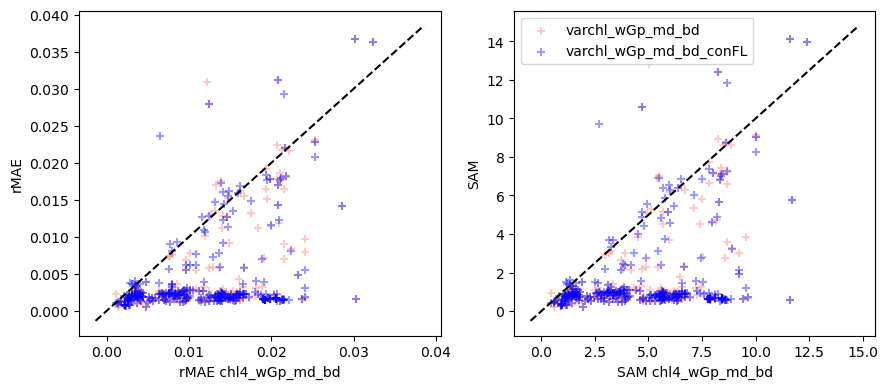

In [20]:
colorMap = plt.cm.get_cmap('Spectral_r')
refKey = "chl4_wGp_md_bd"
Nx = 2
fig, ax = plt.subplots(nrows=1, ncols=Nx, figsize=(9, 4))
for key in SpectralErrorDict.keys():
    if key != refKey:
        ax[0].scatter(SpectralErrorDict[refKey]['rMAE'], SpectralErrorDict[key]['rMAE'], marker='+', c=RrsResultDict[key]['col'], alpha=0.4, label=key)
ax[0].set_xlabel('rMAE ' + refKey)
ax[0].set_ylabel('rMAE')

for key in SpectralErrorDict.keys():
    if key != refKey:
        ax[1].scatter(SpectralErrorDict[refKey]['SAM'], SpectralErrorDict[key]['SAM'], marker='+', c=RrsResultDict[key]['col'], alpha=0.4, label=key)
ax[1].set_xlabel('SAM '+ refKey)
ax[1].set_ylabel('SAM')
ax[1].legend()

for i in range(Nx):
    lim = np.array( (np.min((ax[i].get_xlim(), ax[i].get_ylim())), np.max((ax[i].get_xlim(), ax[i].get_ylim()))))
    ax[i].plot(lim, lim, 'k--')
fig.tight_layout()
plt.show()

In [46]:
print(df.columns.values)

['418.2' '423.9' '429.3' '434.5' '439.6' '444.5' '449.4' '454.2' '458.9'
 '463.6' '468.3' '472.9' '477.6' '482.3' '486.9' '491.6' '496.3' '501.1'
 '505.9' '510.7' '515.5' '520.4' '525.3' '530.3' '535.3' '540.3' '545.4'
 '550.5' '555.7' '560.9' '566.2' '571.6' '577.0' '582.5' '588.0' '593.6'
 '599.3' '605.0' '610.8' '616.7' '622.7' '628.8' '634.9' '641.1' '647.3'
 '653.6' '660.0' '666.4' '672.9' '679.5' '686.1' '692.8' '699.6' '706.4'
 '713.3' '720.3' '727.3' '734.4' '741.6' '748.8' '756.1' '763.5' '770.9'
 '778.3' '785.8' '793.4' 'Date/Time' 'Lat' 'Lon' 'Location' 'Set' 'QWIP'
 'NDI' 'AVW' 'W_Chl' 'W_TSM' 'W_Kd' 'W_CPC' 'Turbidity' 'CDOM' 'Diatoms'
 'Cryptophyta' 'Planktothrix' 'Green_algae' 'Ratio' 'Chl_a' 'Cyano']


chl4_wGp_md_bd 0.001154087150343339 0.03235307360775935
varchl_wGp_md_bd 0.0004816115163567982 0.03673652515641391
varchl_wGp_md_bd_conFL 0.0005956938186558162 0.03672342269553081


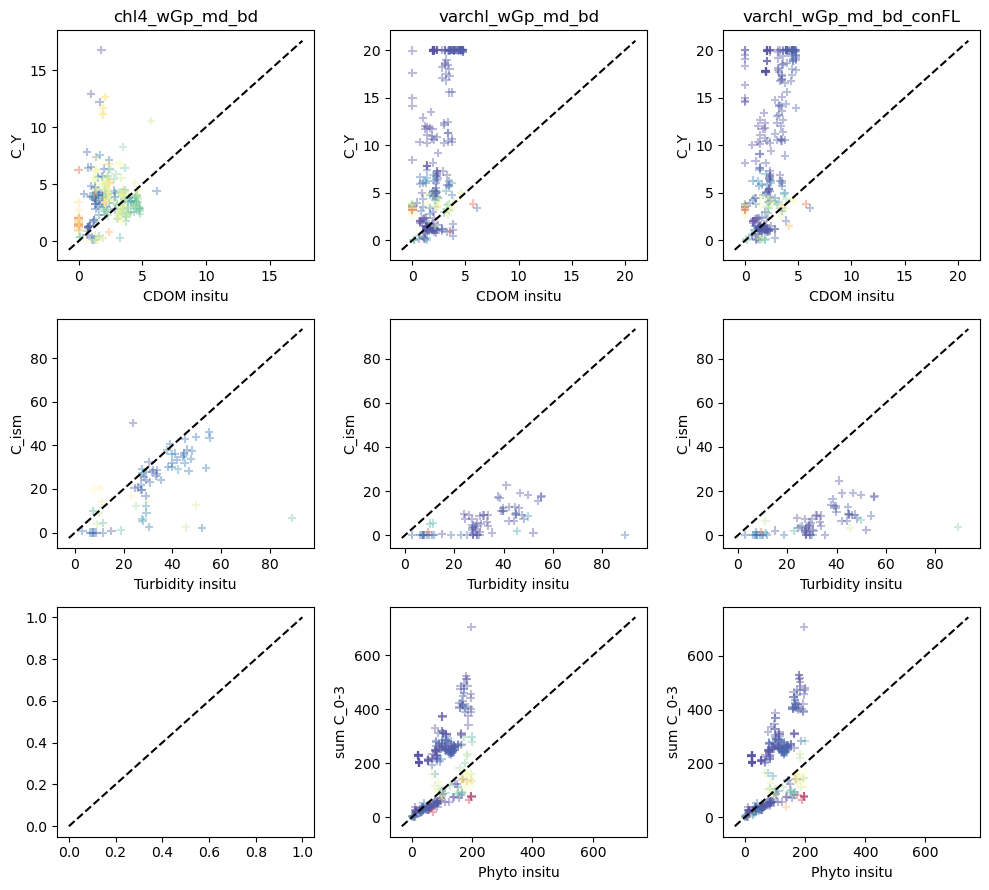

In [21]:
colorMap = plt.cm.get_cmap('Spectral_r')
Nx = 3
Ny = 3

totChl_insitu = np.nansum(df[PhytoConcInsituCol[:4]], axis=1)

fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(10, 9))
for ix, key in enumerate(SpectralErrorDict.keys()):
    ax[0, ix].scatter(df['CDOM'], dDict[key]['C_Y'], marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
    print(key, np.min(SpectralErrorDict[key]['rMAE']), np.max(SpectralErrorDict[key]['rMAE']))

    if 'wG' in key:
        ID = np.array(SpectralErrorDict[key]['negGlintN']>0)
        ax[0, ix].scatter(df['CDOM'].values[ID], dDict[key]['C_Y'].values[ID], marker='x', c=SpectralErrorDict[key]['rMAE'][ID], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
    ax[0, ix].set_xlabel('CDOM insitu')
    ax[0, ix].set_ylabel('C_Y')
    ax[0, ix].set_title(key)

for ix, key in enumerate(SpectralErrorDict.keys()):
    ax[1, ix].scatter(df['Turbidity'], dDict[key]['C_ism'], marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
    if 'wG' in key:
        ID = np.array(SpectralErrorDict[key]['negGlintN']>0)
        ax[1, ix].scatter(df['Turbidity'].values[ID], dDict[key]['C_ism'].values[ID], marker='x', c=SpectralErrorDict[key]['rMAE'][ID], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
    ax[1, ix].set_xlabel('Turbidity insitu')
    ax[1, ix].set_ylabel('C_ism')

phytoList = ['C_0', 'C_1', 'C_2', 'C_3']
for ix, key in enumerate(SpectralErrorDict.keys()):
    if 'varchl' in key:
        totChl = np.sum(dDict[key][phytoList], axis=1)
        ax[2, ix].scatter(totChl_insitu, totChl, marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
        if 'wG' in key:
            ID = np.array(SpectralErrorDict[key]['negGlintN']>0)
            ax[2, ix].scatter(totChl_insitu[ID], totChl[ID], marker='x', c=SpectralErrorDict[key]['rMAE'][ID], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
        ax[2, ix].set_xlabel('Phyto insitu')
        ax[2, ix].set_ylabel('sum C_0-3')


for i in range(Nx):
    for j in range(Ny):
        lim = np.array( (np.min((ax[j,i].get_xlim(), ax[j,i].get_ylim())), np.max((ax[j,i].get_xlim(), ax[j,i].get_ylim()))))
        ax[j,i].plot(lim, lim, 'k--')
fig.tight_layout()
plt.show()

['Diatoms', 'Green_algae', 'Cryptophyta', 'Cyano', 'CDOM', 'Turbidity']
varchl_wGp_md_bd_conFL 0.0005956938186558162 0.03672342269553081


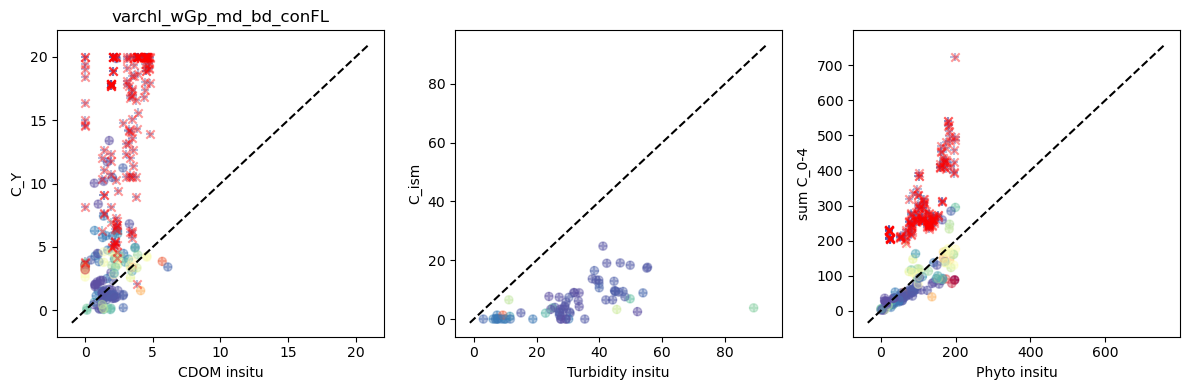

In [22]:
## analyse variable phytoplankton groups and other conc.

colorMap = plt.cm.get_cmap('Spectral_r')
Nx = 3
Ny = 1

print(PhytoConcInsituCol)
totChl_insitu = np.nansum(df[PhytoConcInsituCol[:4]], axis=1)

fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(12, 4))
# key = "varchl_wGp_md_bd"
key = "varchl_wGp_md_bd_conFL"

phytoList = ['C_0', 'C_1', 'C_2', 'C_3', 'C_4']
GoodMatchPhytoTotal = None
relDiffPhyto = None

totChl = np.sum(dDict[key][phytoList], axis=1)
ax[2].scatter(totChl_insitu, totChl, marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
# ax[2].scatter(df['Chl_a'], totChl, marker='x', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
# GoodMatchPhytoTotal = np.array(np.abs(totChl_insitu - totChl)/totChl_insitu <0.3)
GoodMatchPhytoTotal = np.array(1.*totChl_insitu +100. > totChl)
relDiffPhyto = np.abs(totChl_insitu - totChl)/totChl_insitu 
ax[2].scatter(totChl_insitu[GoodMatchPhytoTotal], totChl[GoodMatchPhytoTotal], marker='o', c=SpectralErrorDict[key]['rMAE'][GoodMatchPhytoTotal],
              cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)

WorstMatchPhytoTotal = np.array(1.*totChl_insitu +100.< totChl)
ax[2].scatter(totChl_insitu[WorstMatchPhytoTotal], totChl[WorstMatchPhytoTotal], marker='x', c='red', alpha=0.4)

# if 'wG' in key:
#     ID = np.array(SpectralErrorDict[key]['negGlintN']>0)
#     ax[2].scatter(totChl_insitu[ID], totChl[ID], marker='x', c=SpectralErrorDict[key]['rMAE'][ID], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[2].set_xlabel('Phyto insitu')
ax[2].set_ylabel('sum C_0-4')


ax[0].scatter(df['CDOM'], dDict[key]['C_Y'], marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
print(key, np.min(SpectralErrorDict[key]['rMAE']), np.max(SpectralErrorDict[key]['rMAE']))
if 'wG' in key:
    ID = np.array(SpectralErrorDict[key]['negGlintN']>0)
    ax[0].scatter(df['CDOM'].values[ID], dDict[key]['C_Y'].values[ID], marker='x', c=SpectralErrorDict[key]['rMAE'][ID], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[0].scatter(df['CDOM'].values[GoodMatchPhytoTotal], dDict[key]['C_Y'].values[GoodMatchPhytoTotal], marker='o',
              c=SpectralErrorDict[key]['rMAE'][GoodMatchPhytoTotal], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[0].scatter(df['CDOM'].values[WorstMatchPhytoTotal], dDict[key]['C_Y'].values[WorstMatchPhytoTotal], marker='x', c='red', alpha=0.4)
ax[0].set_xlabel('CDOM insitu')
ax[0].set_ylabel('C_Y')
ax[0].set_title(key)

ax[1].scatter(df['Turbidity'], dDict[key]['C_ism'], marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
if 'wG' in key:
    ID = np.array(SpectralErrorDict[key]['negGlintN']>0)
    ax[1].scatter(df['Turbidity'].values[ID], dDict[key]['C_ism'].values[ID], marker='x', c=SpectralErrorDict[key]['rMAE'][ID], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[1].scatter(df['Turbidity'].values[GoodMatchPhytoTotal], dDict[key]['C_ism'].values[GoodMatchPhytoTotal], marker='o',
              c=SpectralErrorDict[key]['rMAE'][GoodMatchPhytoTotal], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[1].scatter(df['Turbidity'].values[WorstMatchPhytoTotal], dDict[key]['C_ism'].values[WorstMatchPhytoTotal], marker='x', c='red', alpha=0.4)
ax[1].set_xlabel('Turbidity insitu')
ax[1].set_ylabel('C_ism')


for i in range(Nx):
    lim = np.array( (np.min((ax[i].get_xlim(), ax[i].get_ylim())), np.max((ax[i].get_xlim(), ax[i].get_ylim()))))
    ax[i].plot(lim, lim, 'k--')
fig.tight_layout()
plt.show()



['C_0', 'C_1', 'C_2', 'C_3', 'C_4', 'C_Y', 'C_ism', 'L_fl_lambda0', 'L_fl_phycocyanin', 'L_fl_phycoerythrin', 'b_ratio_md', 'b_ratio_bd', 'S_cdom', 'g_dd', 'g_dsr', 'g_dsa', 'd_r', 'fit_surface']


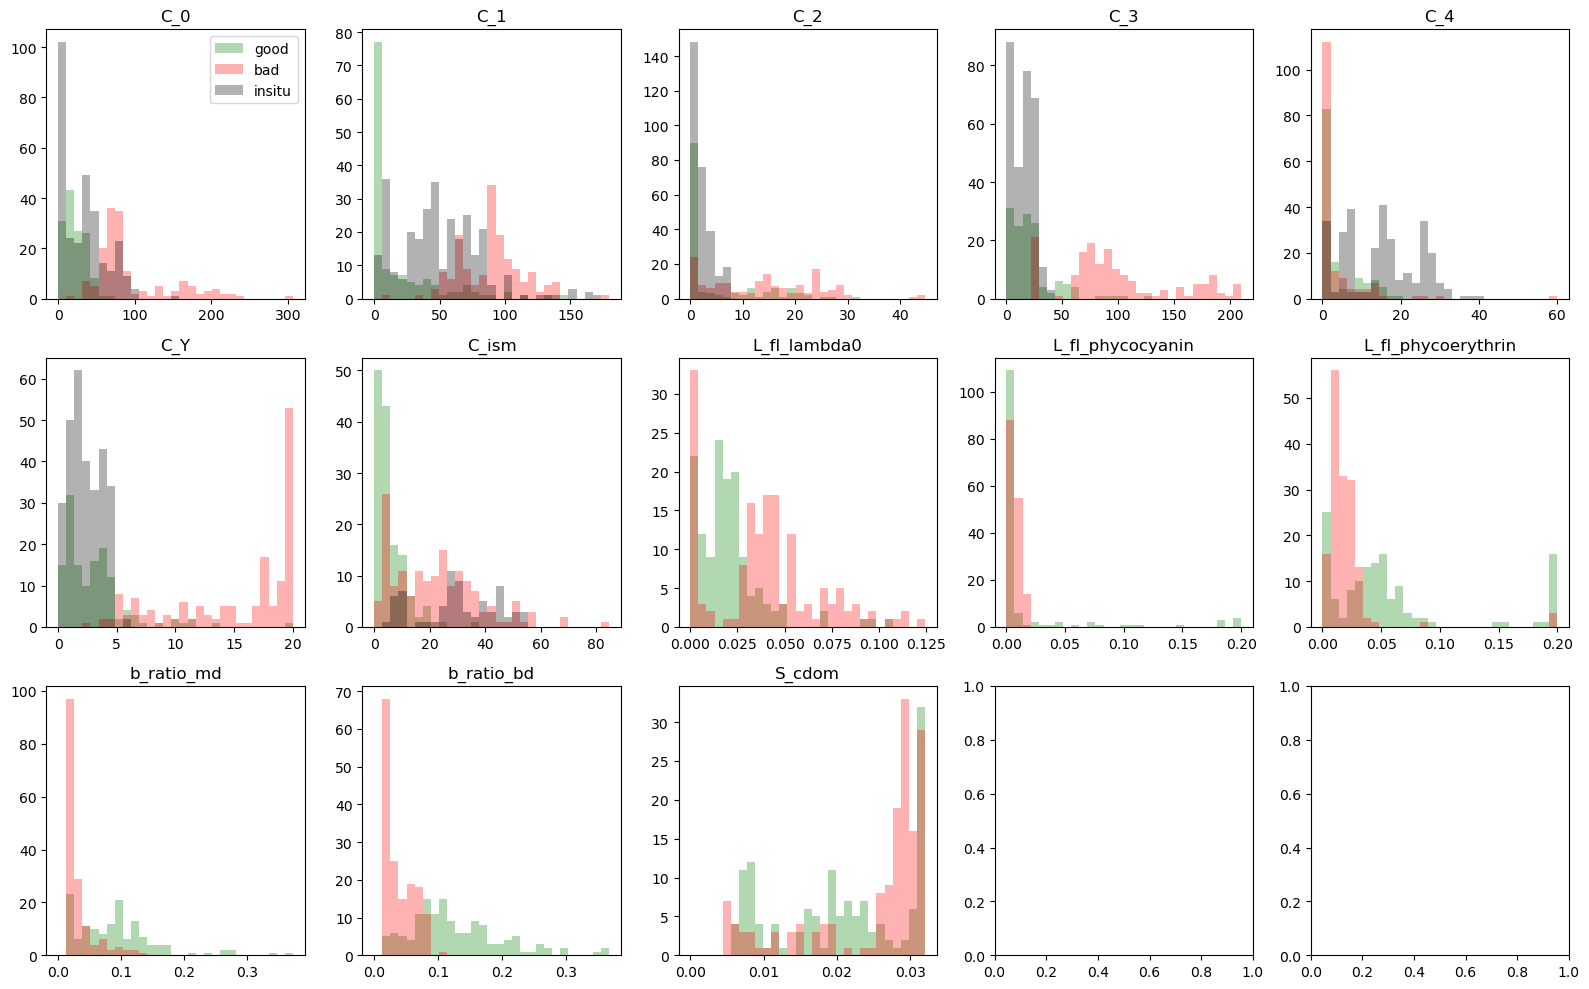

In [23]:
## how do these cases differ, which lead to good or bad agreement with insitu concentrations?
## spectral fit can be very good, but combinations are not!

## Check extreme cases
## histograms free parameters
print(FreeParamList)
#'Diatoms', 'Green_algae', 'Cryptophyta', 'Cyano', 'CDOM', 'Turbidity'
insituList = ['Diatoms', 'Green_algae', 'Cryptophyta', 'Cyano', 'Cyano', 'CDOM', 'Turbidity', None, None, None, None, None, None] 

Nx, Ny = (5, 3)
fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(16,10))
ix, iy = (0, 0)
for i, v in enumerate(FreeParamList[:13]):
    bins = np.linspace(0., np.nanmax(dDict[key][v]), 30)
    ax[iy, ix].hist(dDict[key][v].values[GoodMatchPhytoTotal], bins=bins, alpha=0.3, color='green', label='good')
    ax[iy, ix].hist(dDict[key][v].values[WorstMatchPhytoTotal], bins=bins, alpha=0.3, color='red', label='bad')
    if not insituList[i] is None:
        ax[iy, ix].hist(df[insituList[i]], bins=bins, alpha=0.3, color='black', label='insitu')
        # ax[iy, ix].hist(df[insituList[i]].values[GoodMatchPhytoTotal], alpha=0.3, color='lightgrey')
        # ax[iy, ix].hist(df[insituList[i]].values[WorstMatchPhytoTotal], alpha=0.3, color='darkgrey')
    ax[iy, ix].set_title(v)
    if i == 0:
        ax[iy, ix].legend()
    ix +=1
    if ix==Nx:
        ix=0
        iy+=1

fig.tight_layout()
plt.show()

# ## in log-space
# Nx, Ny = (5, 3)
# fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(16,10))
# ix, iy = (0, 0)
# for i, v in enumerate(FreeParamList[:13]):
#     if v.startswith('C'):
#         bins = np.linspace(-2., np.log10(np.nanmax(dDict[key][v])), 30)
#     elif v.startswith('L_fl'):
#         bins = np.linspace(-3., np.log10(np.nanmax(dDict[key][v])), 30)
#     else:
#         bins = np.linspace(np.log10(np.nanmin(dDict[key][v])), np.log10(np.nanmax(dDict[key][v])), 30)
        
#     ax[iy, ix].hist(np.log10(dDict[key][v].values[GoodMatchPhytoTotal]), bins=bins, alpha=0.3, color='green', label='good')
#     ax[iy, ix].hist(np.log10(dDict[key][v].values[WorstMatchPhytoTotal]), bins=bins, alpha=0.3, color='red', label='bad')
#     if not insituList[i] is None:
#         ax[iy, ix].hist(np.log10(df[insituList[i]]), bins=bins, alpha=0.3, color='black', label='insitu')
#         # ax[iy, ix].hist(df[insituList[i]].values[GoodMatchPhytoTotal], alpha=0.3, color='lightgrey')
#         # ax[iy, ix].hist(df[insituList[i]].values[WorstMatchPhytoTotal], alpha=0.3, color='darkgrey')
#     ax[iy, ix].set_title(v)
#     if i == 0:
#         ax[iy, ix].legend()
#     ix +=1
#     if ix==Nx:
#         ix=0
#         iy+=1

# fig.tight_layout()
# plt.show()

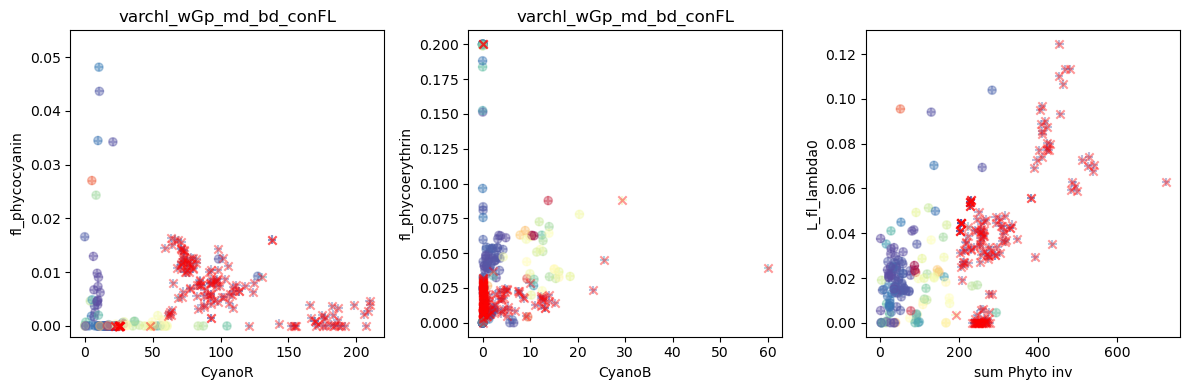

In [34]:
### connection between fluorescence and phytoplankton concentrations ?
colorMap = plt.cm.get_cmap('Spectral_r')
Nx = 3
Ny = 1


fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(12, 4))
ax[2].scatter(totChl, dDict[key]['L_fl_lambda0'], marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[2].scatter(totChl[GoodMatchPhytoTotal], dDict[key]['L_fl_lambda0'][GoodMatchPhytoTotal], marker='o', c=SpectralErrorDict[key]['rMAE'][GoodMatchPhytoTotal],
              cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[2].scatter(totChl[WorstMatchPhytoTotal], dDict[key]['L_fl_lambda0'][WorstMatchPhytoTotal], marker='x', c='red', alpha=0.4)
ax[2].set_xlabel('sum Phyto inv')
ax[2].set_ylabel('L_fl_lambda0')


ax[0].scatter(dDict[key]['C_3'], dDict[key]['L_fl_phycocyanin'], marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[0].scatter(dDict[key]['C_3'].values[GoodMatchPhytoTotal], dDict[key]['L_fl_phycocyanin'].values[GoodMatchPhytoTotal], marker='o',
              c=SpectralErrorDict[key]['rMAE'][GoodMatchPhytoTotal], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[0].scatter(dDict[key]['C_3'].values[WorstMatchPhytoTotal], dDict[key]['L_fl_phycocyanin'].values[WorstMatchPhytoTotal], marker='x',
              c='red', alpha=0.4)
ax[0].set_xlabel('CyanoR')
ax[0].set_ylabel('fl_phycocyanin')
ax[0].set_ylim((-0.002, 0.055))
ax[0].set_title(key)

ax[1].scatter(dDict[key]['C_4'], dDict[key]['L_fl_phycoerythrin'], marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[1].scatter(dDict[key]['C_4'].values[GoodMatchPhytoTotal], dDict[key]['L_fl_phycoerythrin'].values[GoodMatchPhytoTotal], marker='o',
          c=SpectralErrorDict[key]['rMAE'][GoodMatchPhytoTotal], cmap=colorMap, vmin=0.00115, vmax=0.034, alpha=0.4)
ax[1].scatter(dDict[key]['C_4'].values[WorstMatchPhytoTotal], dDict[key]['L_fl_phycoerythrin'].values[WorstMatchPhytoTotal], marker='x',
              c='red', alpha=0.4)
ax[1].set_xlabel('CyanoB')
ax[1].set_ylabel('fl_phycoerythrin')
ax[1].set_title(key)

# for i in range(Nx):
#     ax[i].set_xscale('log')
#     ax[i].set_xlim(0.01, ax[i].get_xlim()[1])



fig.tight_layout()
plt.show()


In [39]:
pred_chl_tot, pred_acdom, pred_TSS = bandratioIOPprediction.predict_start_values_allSensors(r_rs.values, wavelengths, outlierRemoval=True)
pred_chl_tot2, pred_acdom2, pred_TSS2 = bandratioIOPprediction.predict_start_values_allSensors(r_rs.values-R_rs_surf.values, wavelengths, outlierRemoval=True)

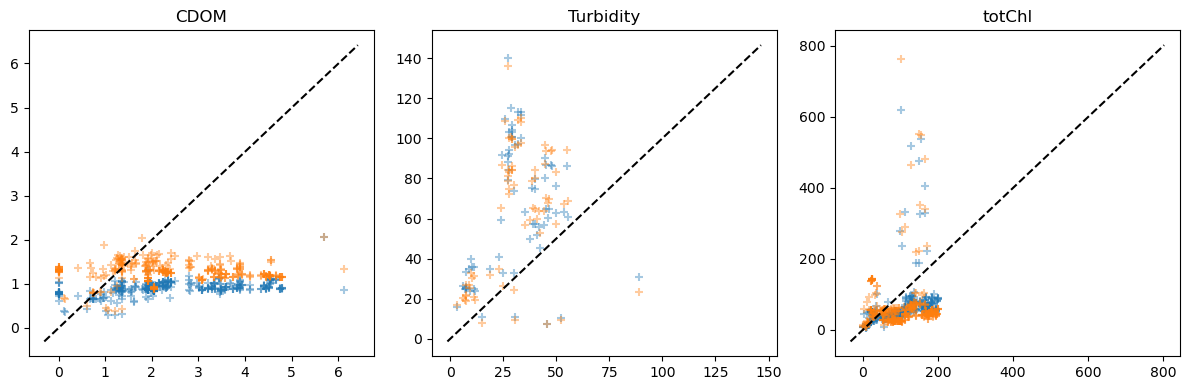

In [40]:
Nx = 3
fig, ax = plt.subplots(nrows=1, ncols=Nx, figsize=(12, 4))
ax[0].scatter(df['CDOM'], pred_acdom, marker='+', alpha=0.4)
ax[0].scatter(df['CDOM'], pred_acdom2, marker='+', alpha=0.4)
ax[0].set_title('CDOM')
ax[1].scatter(df['Turbidity'], pred_TSS, marker='+', alpha=0.4)
ax[1].scatter(df['Turbidity'], pred_TSS2, marker='+', alpha=0.4)
ax[1].set_title('Turbidity')
totChlInsitu=np.sum(df[PhytoConcInsituCol[:-2]], axis=1)
ax[2].scatter(totChlInsitu, pred_chl_tot, marker='+', alpha=0.4)
ax[2].scatter(totChlInsitu, pred_chl_tot2, marker='+', alpha=0.4)
ax[2].set_title('totChl')
for i in range(Nx):
    lim = np.array( (np.min((ax[i].get_xlim(), ax[i].get_ylim())), np.max((ax[i].get_xlim(), ax[i].get_ylim()))))
    ax[i].plot(lim, lim, 'k--')
fig.tight_layout()
plt.show()